In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.optimize import fsolve

In [25]:
class StaticAllocation:
    ###
    # finds allocation of capital and labor across sectors given consumption of manufactured goods
    ###
    
    def __init__(self,
                 α_KA    = 0.15,
                 α_LA    = 0.55,
                 α_KM    = 0.6, 
                 α_LM    = 0.4,
                 X_A     = 1,
                 X_M     = 1,
                 L       = 1,
                 η_A     = 0.15,
                 η_M     = 0.85,
                 γ_A     = 0.3,
                 τ_R     = 0,
                 τ_W     = 0,
                 ):
        
        self.α_KA, self.α_LA = α_KA, α_LA
        self.α_KM, self.α_LM = α_KM, α_LM
        self.X_A,  self.X_M  = X_A , X_M
        self.L               = L
        self.η_A,  self.η_M  = η_A , η_M
        self.γ_A             = γ_A
        self.τ_R,  self.τ_W  = τ_R , τ_W
    
    def Y_A_func(self, κ, K):
        ###
        # the production function for sector A
        ###
        X_A, α_KA, α_LA = self.X_A, self.α_KA, self.α_LA
        L               = self.L
        
        λ = self.λ_func(κ)
        
        K_A = (1 - κ) * K 
        L_A = (1 - λ) * L
        
        Y_A = X_A * (K_A ** α_KA) * (L_A ** α_LA)
        return Y_A
    
    
    def Y_M_func(self, κ, K):
        ###
        # the production function for sector M
        ###
        X_M, α_KM, α_LM = self.X_M, self.α_KM, self.α_LM
        L               = self.L
        
        λ = self.λ_func(κ)
        
        K_M = κ * K 
        L_M = λ * L
        
        Y_M = X_M * (K_M ** α_KM) * (L_M ** α_LM)
        return Y_M
    
    
    def λ_func(self, κ):
        ###
        # finds λ given κ
        ###
        α_KA, α_LA = self.α_KA, self.α_LA
        α_KM, α_LM = self.α_KM, self.α_LM
        η_A , η_M  = self.η_A , self.η_M
        τ_R , τ_W  = self.τ_R , self.τ_W
        
        temp = (α_LA / α_LM) * (α_KM / α_KA) * ((1 + τ_W) / (1 + τ_R)) * ((1 - κ) / κ)
        λ = (1 + temp) ** (-1)
        return λ
    
    
    def κ(self, C_M, K, κ_initial_guess):
        ###
        # equation for κ
        ###
        α_KA      = self.α_KA
        α_KM      = self.α_KM
        η_A, η_M  = self.η_A, self.η_M
        γ_A       = self.γ_A
        τ_R       = self.τ_R
        
        const = (η_M / η_A) * (α_KM / α_KA) * (1 / (1 + τ_R))
        
        func = lambda κ: const * (1 - (γ_A / self.Y_A_func(κ, K))) * (self.Y_M_func(κ, K) / C_M) * ((1 - κ) / κ) - 1
        
        κ_sol = fsolve(func, κ_initial_guess)[0] 
        
        if κ_sol < 1:
            κ = κ_sol
        else:
            κ = 1
        
        return κ
    
    def λ(self, C_M, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.κ(C_M, K, κ_initial_guess)
        λ = self.λ_func(κ)
        
        return λ
    
    
    def Y_A(self, C_M, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.κ(C_M, K, κ_initial_guess)
        Y_A = self.Y_A_func(κ, K)
        
        return Y_A
    
    
    def Y_M(self, C_M, K, κ_initial_guess):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.κ(C_M, K, κ_initial_guess)
        Y_M = self.Y_M_func(κ, K)
        
        return Y_M
    
    def Y_M_prime(self, C_M, K, κ_initial_guess):
        ###
        # derivative of Y_M
        ###
        
        κ    = self.κ(C_M, K, κ_initial_guess)
        α_KM = self.α_KM
        K_M  = K * κ
        Y_M  = self.Y_M_func(κ, K)
        
        Y_M_prime = α_KM * Y_M / K_M
        
        return Y_M_prime

In [26]:
alloc = StaticAllocation()

In [27]:
alloc.κ(C_M = 0.6, K = 2, κ_initial_guess = 0.8)

0.9222982566426594

In [28]:
alloc.Y_M_prime(C_M = 0.6, K = 2, κ_initial_guess = 0.8)

0.4033200187800411

In [29]:
alloc.Y_M(C_M = 0.7, K = 3, κ_initial_guess = 0.9)

1.611461909397815

In [30]:
class PlanningProblemLog(StaticAllocation):

    def __init__(self, β=0.95, δ=0.05):
        
        super().__init__()

        self.β = β
        self.δ = δ

    def u(self, C_M):
        ###
        # utility function
        ###
        u = np.log(C_M)

        return u

    def u_prime(self, C_M):
        ###
        # derivative of utility
        ###
        u_prime = 1/C_M

        return u_prime

    def u_prime_inv(self, C_M):
        ###
        # inverse of derivative of utility
        ###
        u_prime_inv = C_M

        return u_prime_inv
    
    def next_K(self, C_M, K, κ_initial_guess):
        ###
        # return next K
        ###
        δ   = self.δ
        Y_M = self.Y_M(C_M, K, κ_initial_guess)
        Inv = Y_M - C_M
        
        next_K = K * (1 - δ) + Inv
        return next_K
        
    
    def next_C_M(self, C_M, K, κ_initial_guess):
        ###
        # return next C_M
        ###
        β = self.β
        δ = self.δ
        
        next_K = self.next_K(C_M, K, κ_initial_guess)
        
        func = lambda next_C_M: C_M * β * (self.Y_M_prime(next_C_M, next_K, κ_initial_guess) + 1 - δ) - next_C_M
        
        next_C_M_initial_guess = C_M
        next_C_M = fsolve(func, next_C_M_initial_guess)[0]
        
        return next_C_M

In [32]:
ppl = PlanningProblemLog()

In [33]:
ppl.κ(C_M = 0.7, K = 1, κ_initial_guess = 0.8)

0.8870479442167519

In [34]:
ppl.next_K(C_M = 0.7, K = 1, κ_initial_guess = 0.8)

1.0025819798975069

In [35]:
ppl.next_C_M(C_M = 0.8, K = 1.5, κ_initial_guess = 0.9)

1.0420686030295536

In [36]:
def shooting(pp, C_M_0, K_0, κ_initial_guess, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if C_M_0 > pp.Y_M(C_M_0, K_0, κ_initial_guess):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    C_M_vec = np.empty(T+1)
    K_vec   = np.empty(T+2)
    κ_vec   = np.empty(T+1)
    λ_vec   = np.empty(T+1)

    C_M_vec[0] = C_M_0
    K_vec[0] = K_0
    κ_vec[0] = pp.κ(C_M_0, K_0, κ_initial_guess)
    λ_vec[0] = pp.λ(C_M_0, K_0, κ_initial_guess)

    for t in range(T):
        K_vec[t+1]   = pp.next_K(C_M_vec[t], K_vec[t], κ_vec[t])
        C_M_vec[t+1] = pp.next_C_M(C_M_vec[t], K_vec[t], κ_vec[t])
        κ_vec[t+1]   = pp.κ(C_M_vec[t], K_vec[t], κ_vec[t])
        λ_vec[t+1]   = pp.λ(C_M_vec[t], K_vec[t], κ_vec[t]) 
        

    K_vec[T+1] = pp.next_K(C_M_vec[T], K_vec[T], κ_vec[T])

    return C_M_vec, K_vec, κ_vec, λ_vec

In [37]:
paths = shooting(ppl, 0.3, 1, 0.9, T=20)

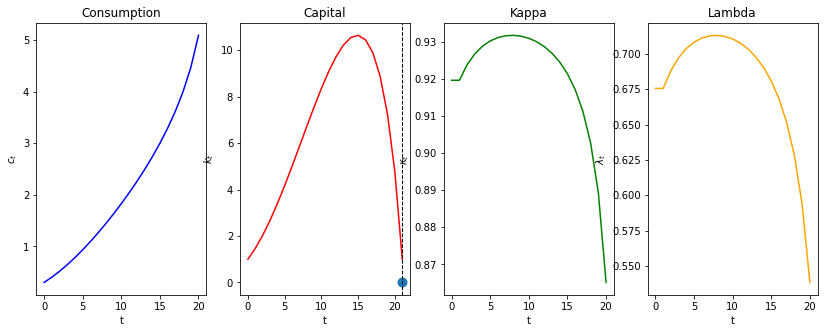

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5))

colors = ['blue', 'red', 'green', 'orange']
titles = ['Consumption', 'Capital', 'Kappa', 'Lambda']
ylabels = ['$c_t$', '$k_t$', '$\kappa_t$', '$\lambda_t$']

T = paths[0].size - 1
for i in range(4):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

axs[1].scatter(T+1, 0, s=80)
axs[1].axvline(T+1, color='k', ls='--', lw=1)

plt.show()

In [39]:
def bisection(pp, c0, k0, κ_initial_guess, T=10, tol=1e-4, max_iter=500, k_ter=0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.Y_M(c0, k0, κ_initial_guess)
    c0_lower = 0

    i = 0
    while True:
        c_vec, k_vec, κ_vec, λ_vec = shooting(pp, c0, k0, κ_initial_guess, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec, κ_vec, λ_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec, κ_vec, λ_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

In [40]:
def plot_paths(pp, c0, k0, κ_initial_guess, T_arr, k_ter=0, k_ss=None, axs=None):

    if axs is None:
        fix, axs = plt.subplots(1, 5, figsize=(16, 4))
    ylabels = ['$c_t$', '$k_t$', '$\mu_t$', '$\kappa_t$', '$\lambda_t$']
    titles = ['M Consumption', 'Capital', 'Lagrange Multiplier',
              'Kappa', 'Lambda']

    c_paths = []
    k_paths = []
    for T in T_arr:
        c_vec, k_vec, κ_vec, λ_vec = bisection(pp, c0, k0, κ_initial_guess, T, k_ter=k_ter, verbose=False)
        c_paths.append(c_vec)
        k_paths.append(k_vec)

        μ_vec = pp.u_prime(c_vec)
        paths = [c_vec, k_vec, μ_vec, κ_vec, λ_vec]

        for i in range(5):
            axs[i].plot(paths[i])
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

        # Plot steady state value of capital
        if k_ss is not None:
            axs[1].axhline(k_ss, c='k', ls='--', lw=1)

        axs[1].axvline(T+1, c='k', ls='--', lw=1)
        axs[1].scatter(T+1, paths[1][-1], s=80)

    return c_paths, k_paths

/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power
/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


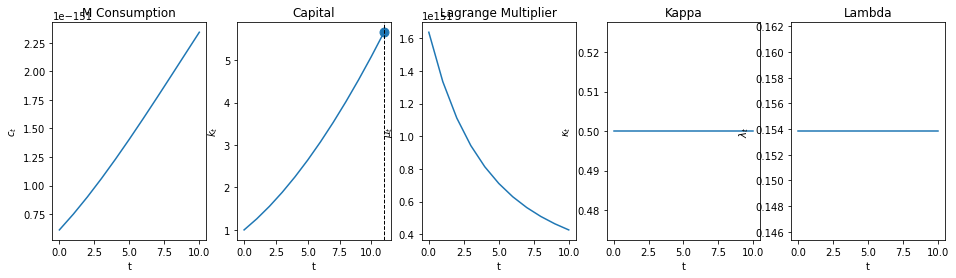

In [41]:
plot_paths(ppl, 0.1, 1, 0.5, [10], k_ter = 10);